# Trabajo Final Inteligencia Artificial I - año 2018: Visión Artificial
---

# [Dependencias y resultados previos](./02-filtracion.ipynb)

## Dependencias

In [1]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

from skimage import io, color, img_as_float, img_as_ubyte, filters

import cv2

In [2]:
def img2gray(image, mode='sk'):
    if (mode=='sk'):
        gray = color.rgb2gray(image)
    elif (mode=='cv'):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

def normSize(image, size=(tuple((400, 300)))):
    image = cv2.resize(image, size)
    return image

def imgClean(image, sigma=1, mode='sk'):
    if (mode == 'sk'):
        clean = filters.gaussian(image, sigma)
    elif (mode == 'cv'):
        clean = cv2.GaussianBlur(img, (3, 3), 0)
    return clean

def imgEdge(image, mode='sk'):
    if (mode == 'sk'):
        edge = filters.sobel(image)
    elif (mode == 'cv'):
        edge = cv2.Laplacian(image, cv2.CV_64F)
    return edge

## Resultados

Text(0.5,1,'filtros gaussian+sobel (negativo)')

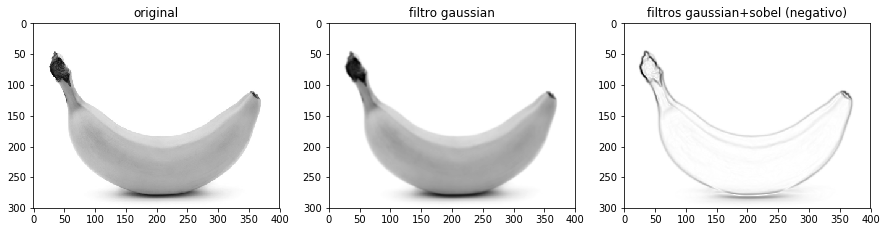

In [3]:
img = io.imread('./examples/banana_example.jpg')

banana = img2gray(img)
banana = normSize(banana)

bg = imgClean(banana)
bc = imgEdge(bg)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 15))
ax0.imshow(banana)
ax0.set_title('original')
ax1.imshow(bg)
ax1.set_title('filtro gaussian')
ax2.imshow(-bc)
ax2.set_title("filtros gaussian+sobel (negativo)")

---

# Segmentado de imágenes
---

El segmentado de las imágenes consiste en extraer de la imágen la información limpia del objeto a analizar, en este caso una banana. Consiste en separar el objeto de su entorno que no provee información útil. Este proceso nos dejará una imagen más limpia de valores binarios, a la que ya se le podrá extraer un determinado tipo de características.

El segmentado puede ser **supervisado** o **no supervisado**. En este trabajo, a pesar de que lo necesario dada la consigna es utilizar segmentado no supervisado, ya que se trabaja con base de datos y luego la clasificación es sin intervención humana, se estudian ambos métodos.

## Histograma

A continuación se realiza un histograma de la imagen filtrada, tanto para $\sigma=10$ como para $\sigma=20$, donde se puede observar la frecuencia con que se repite cierto valor de intensidad en la imagen.

Text(0.5,1,'histograma')

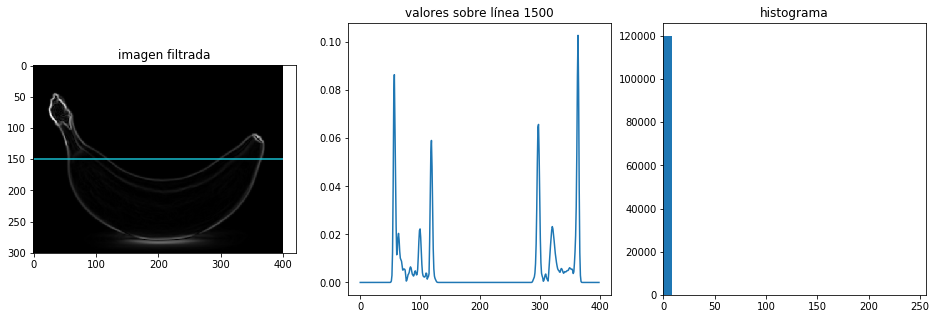

In [5]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
ax0.imshow(bc)
ax0.hlines(bc.shape[0]//2, 0, bc.shape[1], color='C9')
ax0.set_title('imagen filtrada')
ax1.plot(bc[bc.shape[0]//2, :])
ax1.set_title('valores sobre línea 1500')

ax2.hist(bc.ravel(), bins=32, range=[0, 256])
ax2.set_xlim(0, 256);
ax2.set_title('histograma')

Como el histograma no es representativo (imágenes de la derecha), debido a la gran cantidad de negro en la imagen. Se tomo una línea horizontal en 1500, como se indica en las figuras de la izquierda, y se gráfico los valores de la imagen sobre dicha línea (imágenes del centro).
Como puede observarse, los picos alrededor de 100 y 350, que corresponen a los bordes de la banana.

## Thresholding

Esta técnica se utiliza cuando el contraste de la imagen es suficiente para separar un objeto de su entorno. Basicamente consiste en aislar los pixeles por encima o por debajo de un determinado valor, el **threshold**.

### Thresholding supervisado

Se hará una primera implementación supervisada, donde en base a los gráficos anteriores se establece un punto que de buenos resultados. La idea es que si luego las fotografías son tomadas de manera similar, los resultados se pueden generalizar.

Text(0.5,1,'th=0.04')

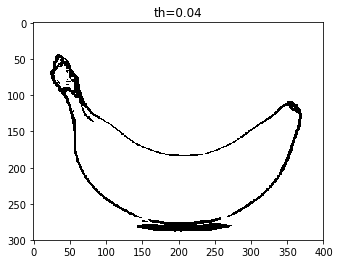

In [6]:
fig, ax = plt.subplots()

ax.imshow(bc < 0.04)
ax.set_title('th=0.04')

### Thresholding no supervisado

Utilizando el módulo de filtros de _skimage_, que provee diferentes métodos no supervisados de thresholding, se obtienen los siguientes resultados:

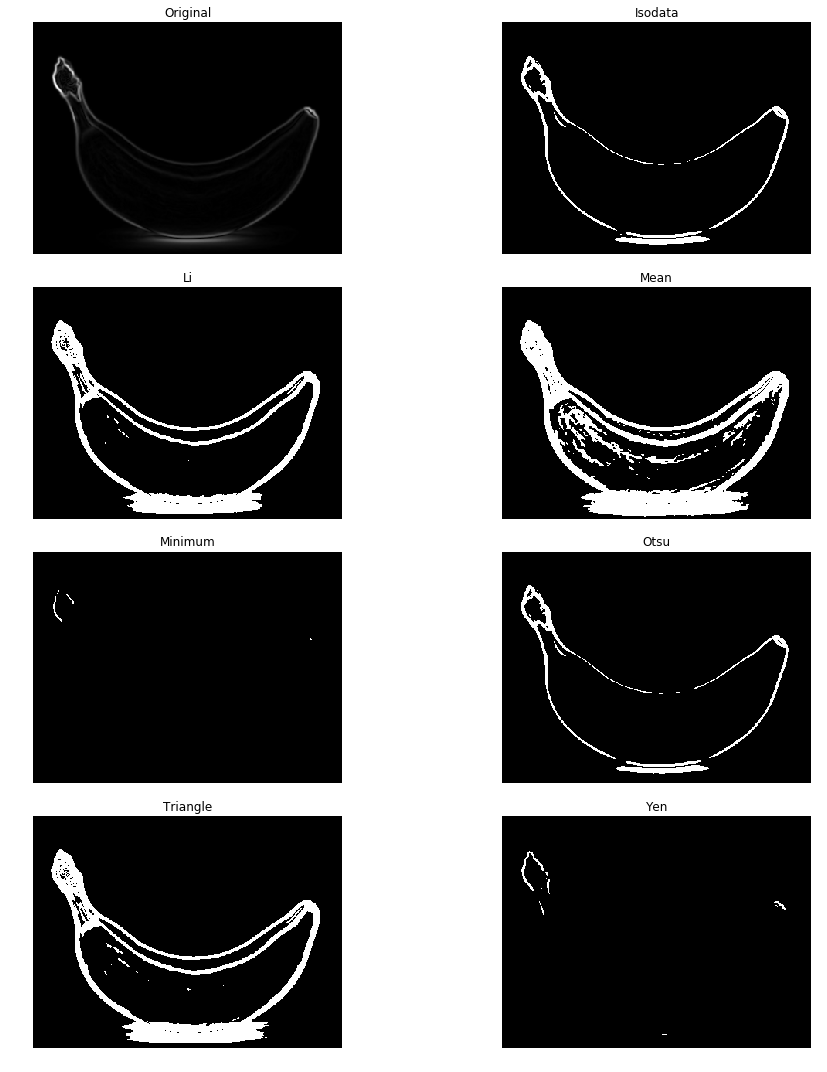

In [7]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(bc, figsize=(15, 15), verbose=False)
plt.show()

Visualmente puede afirmarse que los métodos no supervisados de threshold que dan mejores resultados son _Otsu_ e _Isodata_.

Otro métdo de threshold no supervisado es _local_, siendo su resultado el siguiente:

Text(0.5,1,'threshold local')

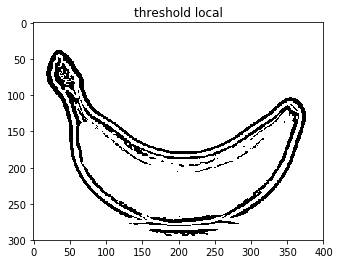

In [8]:
th = filters.threshold_local(bc, 21, offset=0.005)

fig, ax = plt.subplots()

ax.imshow(bc > th)
ax.set_title('threshold local')


## Segmentación activa del contorno

La segmentación activa del contorno es un método de segmentación supervisada, donde se dan parámetros iniciales. Estos parámetros iniciales son los puntos de una curva cerrada.

Básicamente el algoritmo contrae la curva inicial, siendo atraída o repelida por los diferentes valores de intensidad en la imagen. De esta forma llega un punto en el que la curva se adecúa a la forma del objeto.

A pesar de ser supervisada, hay que tener en cuenta que se puede poner como restricción a las fotografías que el objeto sea único en la imagen sobre un fondo lo más limpio posible. De ésta forma se puede utilizar este método dando como curva inicial los límites de la imagen.

In [9]:
def circle_points(resolution, center, radius):
    radians = np.linspace(0, 2*np.pi, resolution)

    c = center[1] + radius*np.cos(radians)
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T

points = circle_points(200, [bc.shape[0]/2, bc.shape[1]/2], 200)[:-1]

In [10]:
import skimage.segmentation as seg

snake = seg.active_contour(bc, points, alpha=0.02)

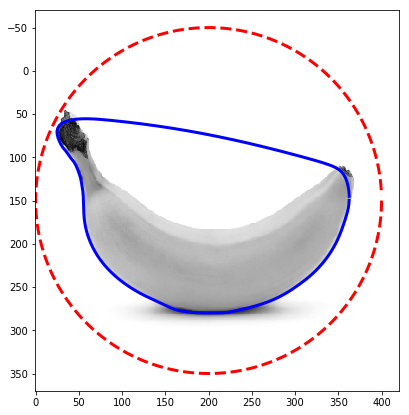

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(banana)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

Se puede observar que dada la forma de la banana el método no es eficiente. Para naranjas y limones no habría problema.

# Resultados
---

El resultado del proceso de segmentación, es una imagen binaria que contendría los bordes del objeto a analizar. Esto puede utilizarse o no, según el método de extracción de características que se utilice.

Text(0.5,1,'threshold isodata')

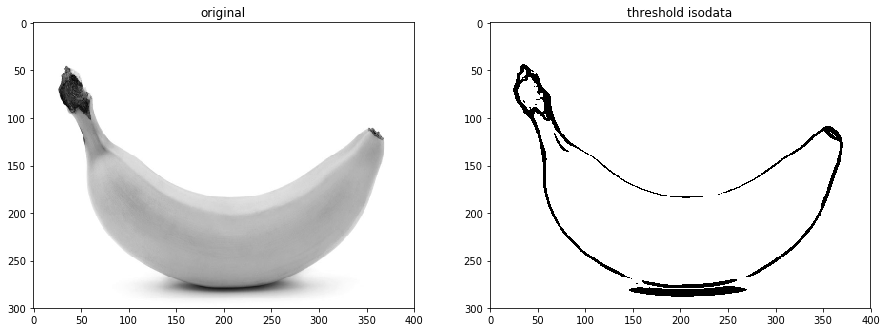

In [14]:
th = filters.threshold_isodata(bc)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))

ax0.imshow(banana)
ax0.set_title('original')
ax1.imshow(bc < th)
ax1.set_title('threshold isodata')

## Funciones

Se define una función que resume la segmentación:
- _threshold(image, mode)_: Recibe la imagen y devuelve la imagen equivalente binaria con threshold isodata. El modo 'sk' indica que es utilizado librería _skimage_, mientras que el modo 'cv' utiliza librería _OpenCV_.

In [15]:
def threshold(image, mode='sk'):
    if (mode == 'sk'):
        th = filters.threshold_isodata(image)
    elif (mode == 'cv'):
        ret, th = cv.threshold(image, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    return (image < th)